# Adrian's Notebook

## Imports

In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

In [3]:
#LABOR POVERTY
df = pd.read_csv("../data/Labor_Poverty.csv", index_col=0) #Imported CSV file
df = df.replace({"ND": None}) #Removed superfluous data
df = df.astype("float") #Changed data types
df.head()

,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
01-2005,34.0,14.4,18.4,41.7,29.6,24.0,69.6,26.4,22.6,43.5,...,22.8,46.7,24.8,25.7,45.6,30.9,45.8,49.4,45.6,52.8
04-2005,32.1,13.8,17.9,42.0,29.1,23.5,69.2,25.5,24.1,43.8,...,23.2,47.5,28.0,23.6,44.1,34.1,46.9,50.6,46.6,51.1
07-2005,32.3,15.1,17.4,42.8,27.7,22.6,68.0,25.8,23.9,42.6,...,23.4,47.8,28.9,25.3,41.2,29.7,47.5,49.1,45.8,49.5
11-2005,30.0,13.4,15.8,39.7,26.5,23.6,69.5,24.5,20.7,39.6,...,22.3,46.2,25.1,23.8,40.8,26.9,44.9,47.9,44.7,46.6
01-2006,31.4,14.3,15.7,41.2,26.6,22.9,67.8,20.5,20.4,40.7,...,20.6,43.6,21.8,21.9,37.9,27.8,45.4,46.2,44.4,51.8


## Data Preprocessing

### Ranking Generator

In [264]:
def yearly_rankings(data, start_year=2005, end_year=2023):
    """"THIS FUNCTION RETURNS A DATAFRAME WITH THE YEARLY RANKINGS OF POVERTY BY STATE (% OF PEOPLE IN LABOR POVERTY)
    OVER A SELECTED RANGE OF YEARS (FIRST PLACE HAS HIGHEST RATE, LAST PLACE HAS LOWEST.)"""
    rank_df = None
    years = [i for i in range(start_year, end_year + 1)]
    df_start = (start_year - 2005) * 4 
    df_end = (end_year - 2005) * 4
    if 2023 in years:
        df_end = 72
    start = df_start
    for i in range((df_end - df_start) // 4 + 1):
        end = start + 4
        batch = data.iloc[start:end,:].mean().sort_values()
        rank_series = pd.Series([i + 1 for i in range(len(batch))], index=batch.index).sort_index()
        if rank_df is None:
            rank_df = pd.DataFrame(rank_series).T
        else:
            rank_df.loc[i] = rank_series.to_dict().values()
        start += 4
        if end >= 72:
            break
    if 2023 in years:
        batch_2023 = data.iloc[df_end,:].sort_values(ascending=False)
        rank_2023 = pd.Series([i + 1 for i in range(len(batch_2023))], index=batch_2023.index).sort_index()
        rank_df.loc[len(rank_df)] = rank_2023.to_dict().values()
    rank_df.index = years
    return rank_df


#To transpose the returned table: yearly_rankings(...).T


## Data Viz

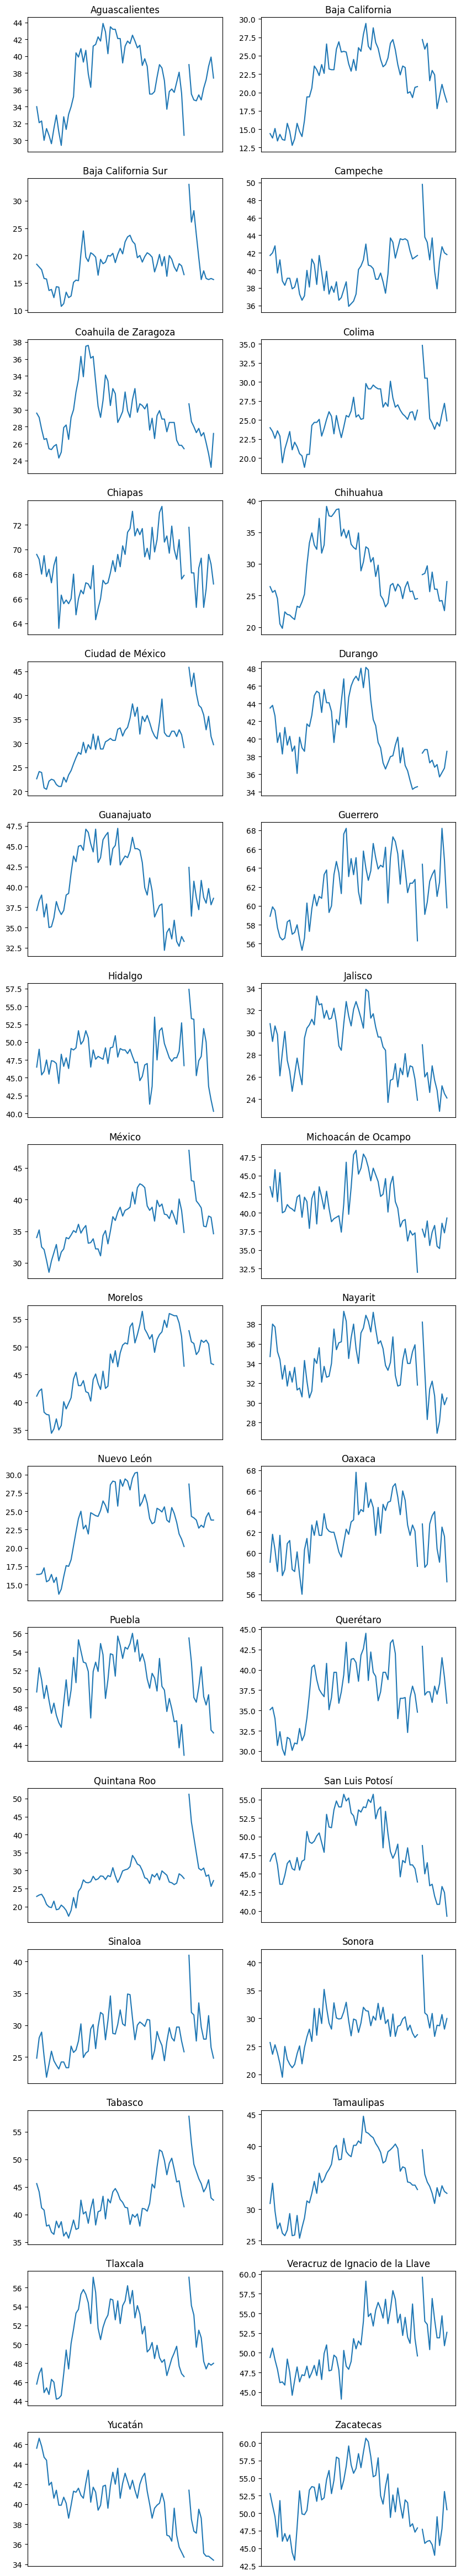

In [5]:
df_graph = df

df_graph.index = pd.to_datetime(df.index, format="%m-%Y") #Might comment out to make sure later code for analysis works under 1.4.

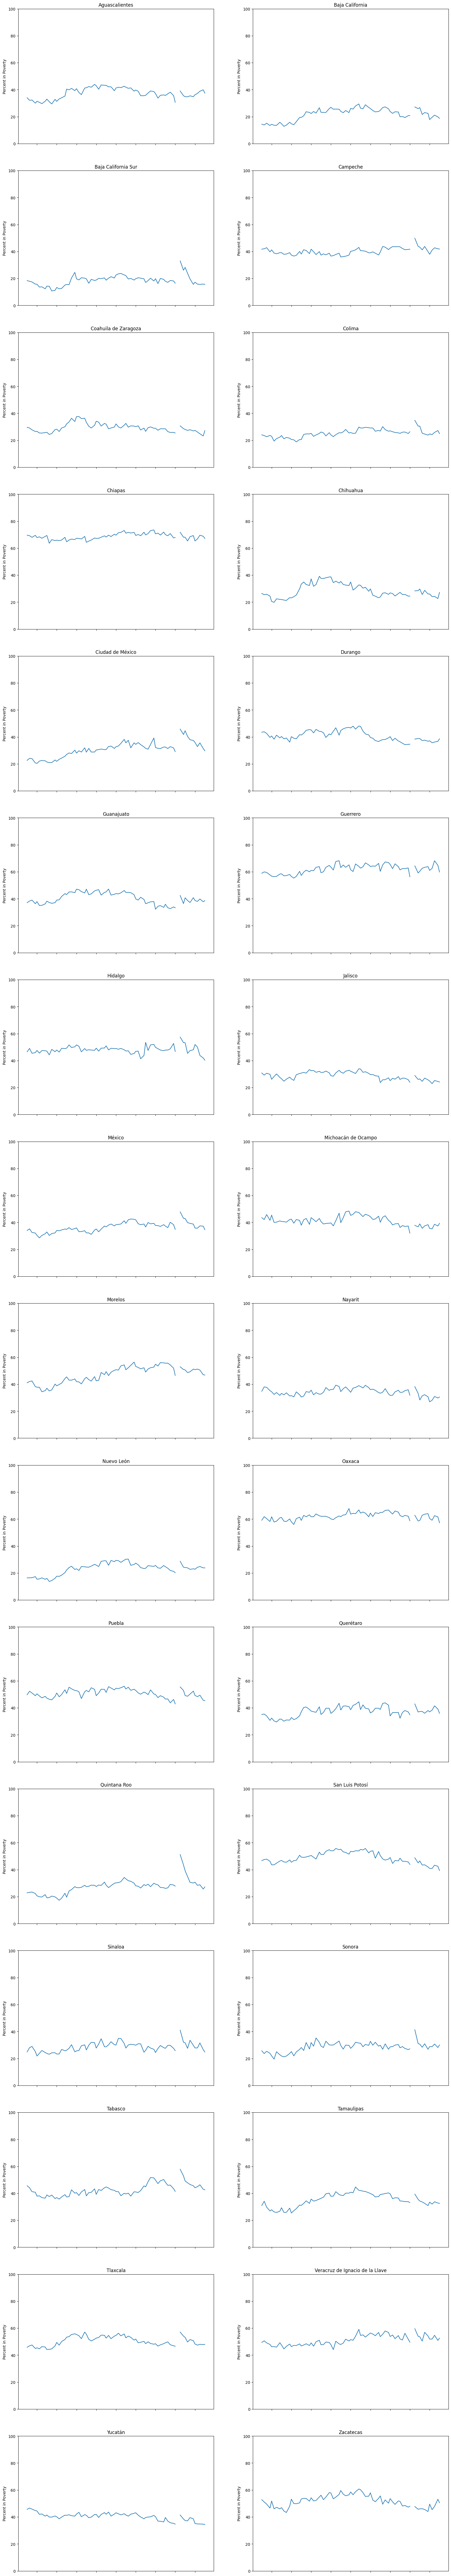

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=16, figsize=(20, 120))
i=0
for row in range(16):
    for col in range(2):
        ax[row,col].set_ylim(0,100)
        ax[row,col].set_ylabel("Percent in Poverty")
        ax[row, col].plot(df_graph.iloc[:, i])
        ax[row, col].set_title(df_graph.columns[i])
        ax[row, col].xaxis.set_major_formatter(plt.NullFormatter()) # Labels removed for cleaner viz
        #ax[row, col].xaxis.set_major_locator(plt.NullLocator()) # Ticks removed for cleaner viz
        i += 1
## TO-DO: toggle xticks to show each 2005, 2006, 2007 at each tick mark.


### Ribon Graph Maker

#### Source Functions

In [85]:
def yearly_averager(df, start_yr, end_yr):
    """CREATES YEAR-OVER AVERAGE RATES DF"""
    yearly_df = None
    for i in range(len(df) // 4 + 1):
        start = i * 4
        end = start + 4
        row = df.iloc[start:end, :].mean(axis=0)
        if yearly_df is None:
            yearly_df = pd.DataFrame(row).T
        else:
            yearly_df.loc[len(yearly_df)] = row
    start = start_yr - 2005
    end = end_yr - 2005 + 1
    yearly_df.index = range(2005, 2024)
    yearly_df = round(yearly_df, 2).T.reset_index()
    yearly_df = yearly_df.rename(columns={"index":"state"})
    col_idx = [i for i in range(start, end)]
    if 0 not in col_idx:
        col_idx.insert(0,0)
    yearly_df = yearly_df.iloc[:, col_idx].sort_values("state")
    return yearly_df

In [80]:
def yearly_ranker(df, start_yr, end_yr):
    """CREATES YEAR-OVER RANKINGS DF"""
    yearly_df = yearly_rankings(df, start_yr, end_yr).T.reset_index()
    yearly_df = yearly_df.rename(columns={"index":"state"})
    return yearly_df

In [290]:
def ribbon_limit_maker(df, start_yr, end_yr):
    """CREATES Y-LIMIT VALUES DF FOR ALL RIBBONS"""
    df_limits = pd.DataFrame(df.state)
    for i, col in enumerate(range(start_yr, end_yr + 1)):
        ch1 = df.loc[:, ['state', col]]
        ch1.sort_values(col, inplace=True)
        ch1[f'y{i}_upper'] = ch1[col].cumsum()
        ch1[f'y{i}_lower'] = ch1[f'y{i}_upper'].shift(1)
        ch1 = ch1.fillna(0)
        ch1[f'y{i}'] = ch1.apply(lambda x: (x[f'y{i}_upper']+x[f'y{i}_lower'])/2, axis=1)
        df_limits = df_limits.merge(ch1.iloc[:, [0, 2, 3, 4]], on='state') 
    
    return df_limits

In [201]:
def getupperlower(df, state):
    ch1 = df.query('state == @state')
    upper_col = [i for i in ch1.columns if 'upper' in i]
    lower_col = [i for i in ch1.columns if 'lower' in i]
    upper_data = ch1[upper_col].values.tolist()[0]
    lower_data = ch1[lower_col].values.tolist()[0]
    annotate_place = ch1['y0'].values.tolist()[0]
    
    return upper_data, lower_data, annotate_place

In [227]:
color_codes = [
        'rgba(255, 0, 0, 128)',     # Red
        'rgba(0, 255, 0, 128)',     # Green
        'rgba(0, 0, 255, 128)',     # Blue
        'rgba(255, 255, 0, 128)',   # Yellow
        'rgba(255, 0, 255, 128)',   # Magenta
        'rgba(0, 255, 255, 128)',   # Cyan
        'rgba(128, 0, 0, 128)',     # Maroon
        'rgba(0, 128, 0, 128)',     # Green (Dark)
        'rgba(0, 0, 128, 128)',     # Navy
        'rgba(128, 128, 0, 128)',   # Olive
        'rgba(128, 0, 128, 128)',   # Purple
        'rgba(0, 128, 128, 128)',   # Teal
        'rgba(255, 128, 0, 128)',   # Orange
        'rgba(255, 0, 128, 128)',   # Pink
        'rgba(128, 255, 0, 128)',   # Lime
        'rgba(128, 0, 255, 128)',   # Indigo
        'rgba(0, 255, 128, 128)',   # Spring Green
        'rgba(0, 128, 255, 128)',   # Sky Blue
        'rgba(255, 128, 128, 128)', # Coral
        'rgba(128, 255, 128, 128)', # Chartreuse
        'rgba(128, 128, 255, 128)', # Orchid
        'rgba(255, 128, 255, 128)', # Hot Pink
        'rgba(128, 255, 255, 128)', # Aqua
        'rgba(255, 255, 128, 128)', # Light Yellow
        'rgba(255, 128, 255, 128)', # Salmon
        'rgba(128, 255, 128, 128)', # Lime Green
        'rgba(128, 128, 255, 128)', # Lavender
        'rgba(255, 128, 128, 128)', # Light Coral
        'rgba(128, 255, 128, 128)', # Pale Green
        'rgba(128, 128, 255, 128)', # Thistle
        'rgba(255, 128, 255, 128)', # Medium Orchid
        'rgba(128, 255, 255, 128)'  # Turquoise
    ]

#### Chart Generator

In [313]:
def ribbon_chart(df, start_year=2005, end_year=2023, states=None):
    """THIS FUNCTION RETURNS A PLOTLY RIBBON CHART WITH THE RANKINGS OF LABOR PPOVERTY IN MEXICO
    (1ST PLACE HAS HIGHEST POVERTY RATE) BASED ON THE FOLLOWING CUSTOM PARAMETERS:
    YEAR RANGE (START, END) AND STATES (LIST).
    """
    if states:
        state_cols = [j for j in df.columns.values for i in states if i.lower() in j.lower()]
        if "cdmx" in [i.lower() for i in states]:
            state_cols.append("Ciudad de México")
        df = df[state_cols]
        
    
    yearly_df = yearly_ranker(df, start_year, end_year) #Creates year-over rankings DF
    yearly_abs_df = yearly_averager(df, start_year, end_year)
    df_limits = ribbon_limit_maker(yearly_df, start_year, end_year) #Creates ribbon limits DF
    x = (np.arange(yearly_df.shape[1]-1)+1).tolist()
    x_rev = x[::-1]

    fig = go.Figure()
    for i, state in enumerate(yearly_df.state):

        upper_col, lower_col,_ = getupperlower(df_limits, state)
        y_upper = upper_col
        y_lower = lower_col
        y_lower = y_lower[::-1]
        fig.add_trace(go.Scatter(
            x=x+[x[-1]+1, x[-1]+1]+x_rev,
            y=y_upper+[y_upper[-1], y_lower[0]]+y_lower,
            fill='toself',
            fillcolor=color_codes[i],
            opacity=0.5,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=state,
            line_shape='spline'
        ))
    start = start_year - 2005
    end = end_year - 2005 + 1
    fig.update_yaxes(showticklabels=True,
                ticktext = [j for j in range(1, len(df.columns) + 1)],
                tickvals = [k for k in range(int(df_limits.iloc[:,1].max()), 0, -int(df_limits.iloc[:,1].max()) // len(df.columns))])
    fig.update_xaxes(range=[1, end - start], tickmode = 'array',showticklabels=True,
                ticktext = [j for j in range(start_year, end_year + 1)],
                tickvals = [k for k in range(1, end)])
    
    
    fig.show()

#ribbon_chart(df, start_year=2015, end_year=2023, states=["aguas", "veracruz", "cdmx", "michoacán"])

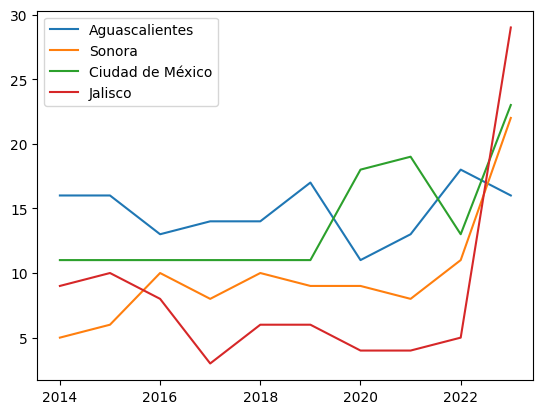

In [295]:
rankings_example = yearly_rankings(df)[["Aguascalientes", "Sonora", "Ciudad de México", "Jalisco"]].iloc[9:19]
rankings_example.plot();

In [298]:
cols = df.columns.values
cols

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila de Zaragoza', 'Colima', 'Chiapas',
       'Chihuahua', 'Ciudad de México', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'México', 'Michoacán de Ocampo',
       'Morelos', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla',
       'Querétaro', 'Quintana Roo', 'San Luis Potosí', 'Sinaloa',
       'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [299]:
tgt_cols = ["aguascalientes", "ciudad de méxico", "michoacán"]

In [305]:
tgt = []
for i in tgt_cols:
    for j in cols:
        if i.lower() in j.lower():
            tgt.append(j)
            break
tgt



['Aguascalientes', 'Ciudad de México', 'Michoacán de Ocampo']